In [2]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scipy.stats as ss
from scipy.optimize import curve_fit
from ntuple_lib import *
beautify_plots(plt)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [7]:
files = ['ntuples_condor/OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(1, 10)]
truth_vtx_z = np.array([], dtype='object')
truth_vtx_z_HS = np.array([], dtype='object')

reco_vtx_z = np.array([], dtype='object')
reco_vtx_z_HS = np.array([], dtype='object')
reco_vtx_sum_pt2 = np.array([], dtype='object')

for file in files:
    root_file = uproot.open(file)
    for key in root_file.keys():
        if key.startswith('EventTree'):
            tree = root_file[key]
            event_truth_vtx_z = tree['truthvertex_z'].array(library='np')
            event_reco_vtx_z = tree['recovertex_z'].array(library='np')
            
            truth_vtx_z = np.concatenate((truth_vtx_z, event_truth_vtx_z))
            reco_vtx_z = np.concatenate((reco_vtx_z, event_reco_vtx_z))
            
            reco_vtx_sum_pt2 = np.concatenate((reco_vtx_z, tree['recovertex_sumPt2'].array(library='np')))
            
            truth_vtx_z_HS = np.concatenate((truth_vtx_z_HS, event_truth_vtx_z[0]))
            reco_vtx_z_HS = np.concatenate((truth_vtx_z_HS, event_reco_vtx_z[0]))

In [35]:
delta_z_max = 10 # plot all within 1 cm

#Only look at truth HS
#For different root(sum pT square) limits
delta_zs_5 = np.array([])
delta_zs_10 = np.array([])
delta_zs_15 = np.array([])
for tr_zs, re_zs, re_sum_pt2 in zip(truth_vtx_z, reco_vtx_z, reco_vtx_sum_pt2):
    ## Loop over all reco
    idxs5 = re_sum_pt2 > 5**2
    idxs10 = re_sum_pt2 > 10**2
    idxs15 = re_sum_pt2 > 15**2
    print(np.sum(idxs5), np.sum(idxs10), np.sum(idxs15))
    
    diff_vec5  = re_zs[idxs5] - tr_zs[0]
    diff_vec10 = re_zs[idxs10] - tr_zs[0]
    diff_vec15 = re_zs[idxs15] - tr_zs[0]
    
    diff_idx5  = np.abs(diff_vec5) < delta_z_max
    diff_idx10 = np.abs(diff_vec10) < delta_z_max
    diff_idx15 = np.abs(diff_vec15) < delta_z_max
    
    delta_zs_5  = np.concatenate((delta_zs_5,   diff_vec5[diff_idx5]))
    delta_zs_10 = np.concatenate((delta_zs_10, diff_vec10[diff_idx10]))
    delta_zs_15 = np.concatenate((delta_zs_15, diff_vec15[diff_idx15]))

27 0 0
24 0 0
31 1 0
34 3 0
22 1 0
35 0 0
33 1 0
28 1 0
32 3 0
27 2 0
28 1 0
29 2 0
28 1 0
27 1 0
24 3 0
30 3 0
34 1 0
23 0 0
23 0 0
23 0 0
27 1 0
32 2 0
18 0 0
22 0 0
19 0 0
23 1 0
27 2 0
26 3 0
27 0 0
29 1 0
29 0 0
34 1 0
22 1 0
25 1 0
26 0 0
27 1 0
26 2 0
29 1 0
27 3 0
26 3 0
29 1 0
29 1 0
28 2 0
33 1 0
33 0 0
30 0 0
24 0 0
34 2 0
24 1 0
20 4 0
38 1 0
26 2 0
30 4 0
31 1 0
34 0 0
33 1 0
27 4 0
34 1 0
36 1 0
28 2 0
28 1 0
31 3 0
30 1 0
31 3 0
28 0 0
28 1 0
33 4 0
33 1 0
35 0 0
30 3 0
32 1 0
23 0 0
33 1 0
24 1 0
31 1 0
32 3 0
34 1 0
31 1 0
29 1 0
32 4 0
23 1 0
32 3 0
30 2 0
30 0 0
27 0 0
32 1 0
24 1 0
28 0 0
25 0 0
32 2 0
28 2 0
29 1 0
26 3 0
35 4 0
30 0 0
29 6 0
21 0 0
21 1 0
27 2 0
29 2 0
25 0 0
25 0 0
35 5 0
27 1 0
34 0 0
29 0 0
22 0 0
28 1 0
39 1 0
26 0 0
29 2 0
24 1 0
32 3 0
33 1 0
23 1 0
26 0 0
21 1 0
26 1 0
31 1 0
34 1 0
28 1 0
34 3 0
30 3 0
23 1 0
27 2 0
31 2 0
24 0 0
22 3 0
35 2 0
28 3 0
23 1 0
28 0 0
22 2 0
24 1 0
31 2 0
31 1 0
24 1 0
23 4 0
35 0 0
23 0 0
26 1 0
35 3 0
38 2 0

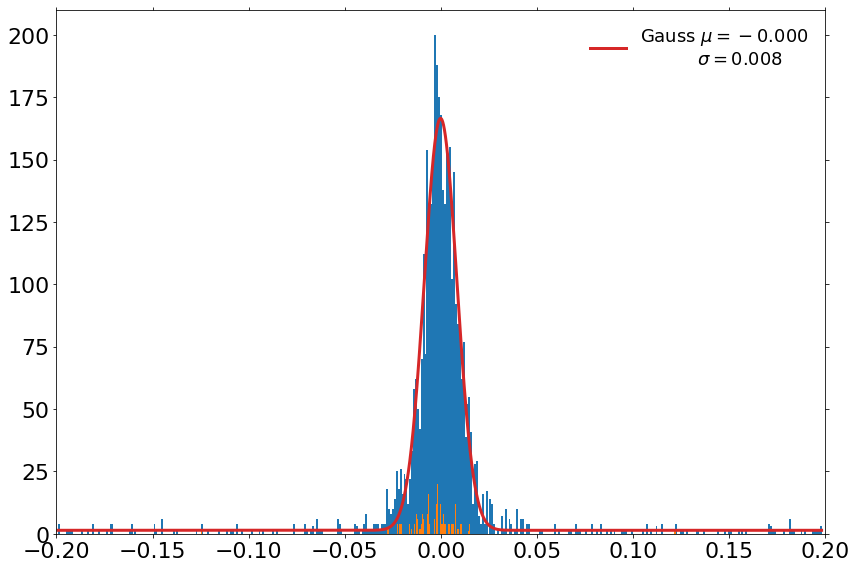

In [31]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

dz_plot_max = 0.2

idx1 = np.abs(delta_zs_5)  < dz_plot_max
idx2 = np.abs(delta_zs_10) < dz_plot_max
idx3 = np.abs(delta_zs_15) < dz_plot_max

bin_heights1, bin_borders1, _ = ax.hist(delta_zs_5 [idx1], bins = 400)
_ = ax.hist(delta_zs_10[idx2], bins = 400)
_ = ax.hist(delta_zs_15[idx3], bins = 400)

bin_centers1 = bin_borders1[:-1] + np.diff(bin_borders1) / 2
popt1, _ = curve_fit(gaussian, bin_centers1, bin_heights1, p0=[2500., 0., 0.03, 0])

#Plot fit
x_interval_for_fit = np.linspace(bin_borders1[0], bin_borders1[-1], 10000)
ax.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt1), lw=3, label='Gauss $\\mu={:.3f}$\n          $\\sigma={:.3f}$'.format(popt1[1], popt1[2]))

ax.legend(frameon=False)
ax.set_xlim(-dz_plot_max, dz_plot_max)

fig.tight_layout()

In [26]:
# For each event compare all V_truth and V_reco z-positions
delta_zs_min = []
for tr_zs, re_zs in zip(truth_vtx_z, reco_vtx_z):
    xv, yv = np.meshgrid(tr_zs, re_zs)
    diff_matrix = xv-yv
    for r in diff_matrix:
        idx = np.argmin(np.abs(r))
        delta_zs_min.append(r[idx])
delta_zs_min = np.array(delta_zs_min)

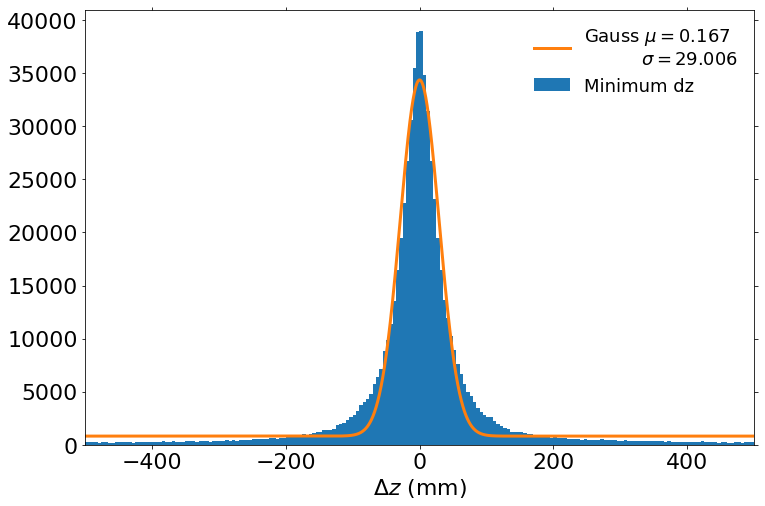

In [27]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

z_lim = 500

bin_heights, bin_borders, _ = ax.hist(1e3*delta_zs_min[np.abs(1e3*delta_zs_min) < z_lim], 200, label='Minimum dz')

bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[10000., 0., 30, 0])

#Plot fit
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
ax.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), lw=3, label='Gauss $\\mu={:.3f}$\n          $\\sigma={:.3f}$'.format(popt[1], popt[2]))


ax.set_xlim(-z_lim, z_lim)
ax.set_xlabel('$\\Delta z$ (mm)')
ax.legend(frameon=False)